# Análise de dados

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime

from IPython.display import display, Latex, Math, Markdown
from scipy.stats import chisquare

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import math
import pytz
import pandas as pd
import shutil

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [3]:
wifi   = spark.read.parquet("./data/ds/wifi-log.parquet")
gps    = spark.read.parquet("./data/ds/gps-log.parquet")
oui    = spark.read.parquet("./data/ds/oui.parquet")
survey = spark.read.parquet("./data/ds/survey.parquet")

In [4]:
phones = wifi.join(oui.dropDuplicates(["prefix"]), substring("mac", 0, 8) == col("prefix"))
makers = phones.groupBy("maker").count().orderBy(desc("count"))

wifi_total = wifi.count()
phones_total = phones.count()

totals = spark.createDataFrame([
    ("Celulares", phones_total, "%.2f%%" % (phones_total / wifi_total * 100)),
    ("Total",  wifi_total, "100%")
], ["", "count", "P"])
totals.toPandas()

,,count,P
0,Celulares,721846,79.57%
1,Total,907168,100%


In [5]:
to_percentage = lambda col_name, total: format_string("%.2f%%", col(col_name) / total * 100)

makers = makers.withColumn("share", to_percentage("count", phones_total))
makers.toPandas().head()

,maker,count,share
0,Samsung,258449,35.80%
1,Motorola,201424,27.90%
2,Lenovo,155135,21.49%
3,LG,47524,6.58%
4,Apple,27201,3.77%


In [6]:
from operator import add

OTHERS_THRESHOLD = 7000

count = makers.filter(col("count") < OTHERS_THRESHOLD).rdd.map(lambda x: x["count"]).reduce(add)
share = "%.2f%%" % (count / phones_total * 100)

others = spark.createDataFrame([("Outros", count, share)], ["maker", "count", "share"])
others.toPandas()

,maker,count,share
0,Outros,9125,1.26%


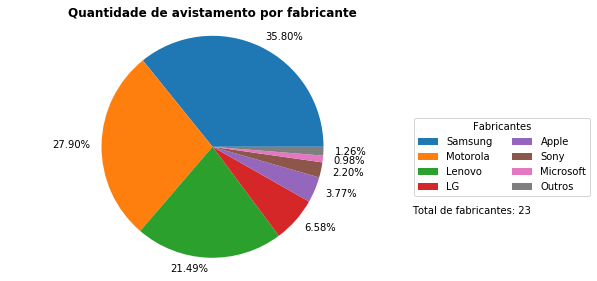

In [7]:
m = makers.filter(col("count") > OTHERS_THRESHOLD).unionAll(others).toPandas()

# 'tab20', 'tab20b', 'tab20c'
# patches.set_cmap("tab20b")

patches, texts = plt.pie(m['count'], labels=m['share'], startangle=0)
plt.title("Quantidade de avistamento por fabricante", {'fontweight':'bold'})
plt.text(1.8, -0.6, "Total de fabricantes: %d" % makers.count())
plt.legend(patches, m['maker'], ncol=2, loc=(1, 0.3), title="Fabricantes")
plt.axis('equal')
plt.tight_layout()

In [8]:
market_share_real = pd.DataFrame({'OS': ['Android', 'iOS', 'Windows Phone', 'Outros'], 
                             'share': [0.845, 0.1004, 0.0183, 0.0363]})
market_share_real

,OS,share
0,Android,0.8450
1,iOS,0.1004
2,Windows Phone,0.0183
3,Outros,0.0363


In [9]:
def get_os(x):
    if x in ['Samsung', 'Motorola', 'Lenovo', 'LG', 'Sony']:
        return "Android"
    elif x in ['Apple']:
        return 'iOS'
    elif x in ['Microsoft']:
        return 'Windows Phone'
    else:
        return 'Outros'
    
os = udf(get_os)

market_share_wifi = (
    makers
    .withColumn("OS", os("maker"))
    .groupBy("OS")
    .agg(sum("count").alias("count"))
    .withColumn("share", col("count") / lit(phones_total))
    .drop("count")
)

market_share = market_share_wifi.toPandas().merge(market_share_real, on=['OS'],
                                                  how='left', suffixes=('_wifi', '_real'))
value, p_value = chisquare(market_share.share_wifi, market_share.share_real)

display(market_share)

display(Math(r"""\chi^2 = %.4f""" % value))
display(Math(r"""\textit{valor-P} = %.4f""" % (1-p_value)))

,OS,share_wifi,share_real
0,iOS,0.037683,0.1004
1,Outros,0.012641,0.0363
2,Windows Phone,0.009818,0.0183
3,Android,0.939858,0.8450


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
phones_ds = (
    phones
    .withColumn("date", date_format("timestamp", "dd/MM/yyyy"))
    .withColumn("timestamp", to_utc_timestamp(regexp_replace("timestamp", ",", "."), "UTC"))
    .drop("level", "organization", "prefix")
)
phones_ds.groupBy("date").count().orderBy("date").toPandas()

,date,count
0,06/12/2017,130846
1,07/12/2017,77263
2,08/12/2017,156245
3,11/12/2017,79781
4,12/12/2017,111371
5,13/12/2017,64330
6,29/11/2017,102010


In [11]:
mins = lambda i: i * (60*60)

IS_PASSENGER_THRESHOLD = 10

repeated_sightings = (
    Window.partitionBy("mac")
    .orderBy(col("timestamp").cast("long"))
    .rangeBetween(0, 5)
)

sightings = (
    phones_ds
    # 1) Remove repeated sightings 
    .withColumn("fst_sight", first("timestamp").over(repeated_sightings))
    .filter(col("fst_sight") == col("timestamp"))
    .drop("fst_sight")
    # 2) Group sightings in a sliding windown of 5 minutes each minute
    .groupBy(window("timestamp", "5 minutes", "1 minute"))
    .agg(collect_list("mac").alias("addresses"))
    .orderBy("window")
    # 3) Filter adresses only sighted few times within the window
    .select("window", explode("addresses").alias("mac"))
    .groupBy("window", "mac").count()
    .filter(col("count") > IS_PASSENGER_THRESHOLD)
    .drop("count")
    # 4) Estimate the occupation
    .groupBy("window").count()
    .withColumn("date", date_format("window.start", "dd/MM/yyyy"))
).cache()

# Summary
(
    sightings
    .withColumn("day", date_format("window.start", "EEEE"))
    .groupBy("date")
    .agg(
        first("day").alias("day"), 
        sum("count").alias("total")
    )
).toPandas()

,date,day,total
0,12/12/2017,Tuesday,10625
1,08/12/2017,Friday,15329
2,06/12/2017,Wednesday,11784
3,11/12/2017,Monday,7580
4,29/11/2017,Wednesday,9080
5,07/12/2017,Thursday,5655
6,13/12/2017,Wednesday,5935


## Escala de classificação da ocupação de um veículo.

|  Número | Descrição | Definição |
|:-------:|:----------|:----------|
| 1 | Parcialmente sentados | Alguns lugares vazios |
| 2 | Sentados | Todos os bancos ocupados |
| 3 | 25% de ocupação | Todos os bancos ocupados com algumas pessoas em pé |
| 4 | 50% de ocupação | Meia lotação do corredor |
| 5 | 75% de ocupação | Lotação de 3/4 do veículo |
| 6 | 90% de ocupação | Apesar de lotado, observa-se que tem capacidade para atender mais usuários |
| 7 | Lotado | Capacidade total utilizada |
| 8 | Superlotado | Além da capacidade normal |

In [12]:
MAX_OCCUPATION = (58 + 118)

def get_occupation(sightings):
    if sightings < 58:
        return 1
    elif sightings >= 58 and sightings < 86:
        return 2
    elif sightings >= 86 and sightings < 116:
        return 3
    elif sightings >= 117 and sightings < 146:
        return 4
    elif sightings >= 146 and sightings < 164:
        return 5
    elif sightings >= 164 and sightings < MAX_OCCUPATION:
        return 6
    elif sightings >= MAX_OCCUPATION and sightings < MAX_OCCUPATION * 1.1:
        return 7
    else:
        return 8
    
def get_occupation_percentage(sightings):
    if sightings < MAX_OCCUPATION * 0.15:
        return 1
    elif sightings >= MAX_OCCUPATION * 0.15 and sightings < MAX_OCCUPATION * 0.25:
        return 2
    elif sightings >= MAX_OCCUPATION * 0.25 and sightings < MAX_OCCUPATION * 0.40:
        return 3
    elif sightings >= MAX_OCCUPATION * 0.40 and sightings < MAX_OCCUPATION * 0.60:
        return 4
    elif sightings >= MAX_OCCUPATION * 0.60 and sightings < MAX_OCCUPATION * 0.80:
        return 5
    elif sightings >= MAX_OCCUPATION * 0.80 and sightings < MAX_OCCUPATION:
        return 6
    elif sightings >= MAX_OCCUPATION and sightings < MAX_OCCUPATION * 1.1:
        return 7
    else:
        return 8

occupation = udf(lambda x: get_occupation_percentage(x), IntegerType())

occupation = sightings.withColumn("occupation", occupation("count")).cache()   

(
    occupation
    .withColumn("day", date_format("window.start", "EEEE"))
    .withColumn("date", date_format("window.start", "dd/MM/yyyy"))
    .groupBy("date")
    .agg(
        first("day").alias("day"), 
        date_format(first("window.start"), "HH:mm:ss").alias("start"), 
        date_format(last("window.end"), "HH:mm:ss").alias("end"),
        avg("occupation")
    )
    .orderBy("date")
).toPandas()

,date,day,start,end,avg(occupation)
0,06/12/2017,Wednesday,18:47:00,21:28:00,3.585987
1,07/12/2017,Thursday,07:48:00,09:41:00,2.733945
2,08/12/2017,Friday,19:55:00,22:26:00,4.428571
3,11/12/2017,Monday,08:14:00,10:23:00,3.048000
4,12/12/2017,Tuesday,18:59:00,21:43:00,3.237500
5,13/12/2017,Wednesday,12:44:00,15:01:00,2.421053
6,29/11/2017,Wednesday,05:43:00,09:50:00,2.127572


### Corridas de ida e volta

Cria uma lista com os horários de ínicio e fim das corridas de de ida e volta

In [13]:
ride_finished = (
    survey
    .filter(col("occupation") == 8)
    .select(
        date_format("timestamp", "yyyy-MM-dd").alias("date"), 
        col("timestamp").alias("finisedAt")
    )
).toPandas().set_index("date").to_dict("index")

def get_direction(timestamp):
    date = timestamp.strftime("%Y-%m-%d")
    return 0 if timestamp < ride_finished[date]['finisedAt'] else 1

direction = udf(lambda ts: get_direction(ts), IntegerType())

trips = (
    survey
    .filter(col("occupation") != 8)
    .withColumn("direction", direction("timestamp"))
    .groupBy("date", "direction")
    .agg(
        min("timestamp").alias("start"),
        max("timestamp").alias("end")
    )
    .orderBy("start")
    .drop("date")
    .select(date_format("start", "dd/MM/yyyy").alias("date"), "*")
)

trips.toPandas()

,date,direction,start,end
0,29/11/2017,0,2017-11-29 07:56:27.382,2017-11-29 08:41:05.250
1,29/11/2017,1,2017-11-29 08:56:30.880,2017-11-29 09:45:36.779
2,06/12/2017,0,2017-12-06 19:03:06.024,2017-12-06 20:02:25.675
3,06/12/2017,1,2017-12-06 20:10:23.736,2017-12-06 21:23:48.118
4,07/12/2017,0,2017-12-07 07:56:47.934,2017-12-07 08:40:03.281
5,07/12/2017,1,2017-12-07 08:45:18.160,2017-12-07 09:36:31.212
6,08/12/2017,0,2017-12-08 19:24:08.767,2017-12-08 20:35:35.730
7,08/12/2017,1,2017-12-08 21:01:20.958,2017-12-08 22:21:25.070
8,11/12/2017,0,2017-12-11 08:26:26.368,2017-12-11 09:18:52.899
9,11/12/2017,1,2017-12-11 09:23:40.758,2017-12-11 10:18:28.142


In [14]:
# Graph properties
real_color = "#9A9DAA"
wifi_color = "#27A3DD"
title_kwargs = {'fontsize': 10, 'fontweight': 'bold', 'y': 1.08}
text_kwargs = {'fontsize': 8}
labels_kwargs = {'fontsize': 6, 'rotation': 90}
span_kwargs = {'facecolor': '#EEEEEE', 'alpha': 0.8, 'lw': 1, 'ls':'-', 'edgecolor': '#FFFFFF'}

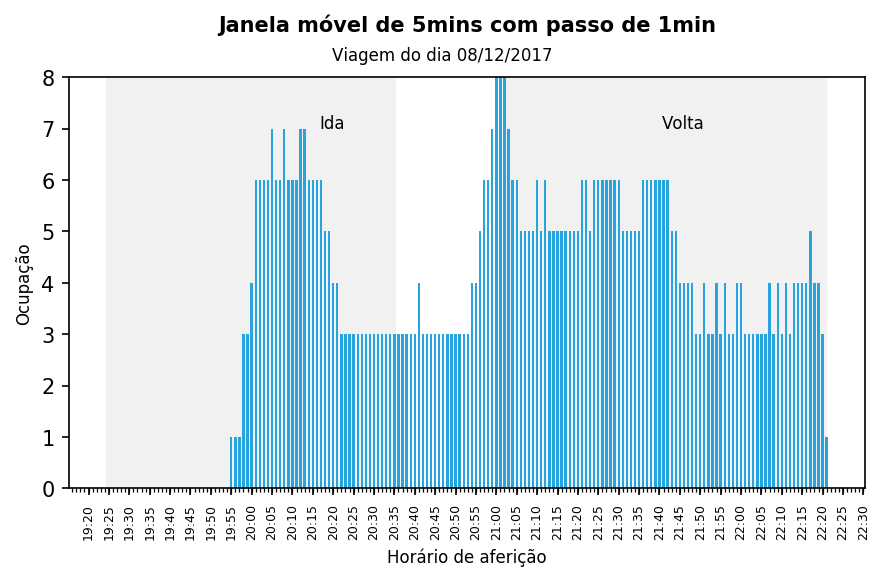

In [15]:
date = "08/12/2017"

# Get the start/end timestamps for the round trip
a = trips.filter((col("date") == date) & (col("direction") == 0)).select("start", "end").first()
b = trips.filter((col("date") == date) & (col("direction") == 1)).select("start", "end").first()

r = occupation.filter(col("date") == date).cache().toPandas()
r = r.set_index(r["window"].map(lambda x: x[0]))

x = np.arange(len(r))

fig, ax = plt.subplots(dpi=150, figsize=(6, 4))

# Draw the first trip area
asi = r.index.get_loc(a['start'], method='nearest') 
aei = r.index.get_loc(a['end'],   method='nearest')
# ax.axvspan(r.iloc[asi]['window'][0], r.iloc[aei]['window'][1], **span_kwargs)
ax.axvspan(a['start'], a['end'], **span_kwargs)

# Draw the second trip area
bsi = r.index.get_loc(b['start'], method='nearest')
bei = r.index.get_loc(b['end'],   method='nearest')
# ax.axvspan(r.iloc[bsi]['window'][0], r.iloc[bei]['window'][1], **span_kwargs)
ax.axvspan(b['start'], b['end'], **span_kwargs)

# Draw the occupation graph
ax.bar(r.index, r['occupation'], width=0.0004, color=wifi_color)

mAX = mdates.date2num(r.ix[asi]['window']['start']) + (mdates.date2num(r.ix[aei]['window']['end']) - mdates.date2num(r.ix[asi]['window']['start'])) / 2
mBX = mdates.date2num(r.ix[bsi]['window']['start']) + (mdates.date2num(r.ix[bei]['window']['end']) - mdates.date2num(r.ix[bsi]['window']['start'])) / 2

# Labels
ax.annotate("Ida",   xy=(mAX - 0.001, 7), **text_kwargs)
ax.annotate("Volta", xy=(mBX - 0.002, 7), **text_kwargs)

# Prepare the graph
ax.set_title("Janela móvel de 5mins com passo de 1min", **title_kwargs)
ax.set_ylabel("Ocupação", **text_kwargs)
ax.set_xlabel("Horário de aferição", **text_kwargs)
ax.axes.set_ybound(0, 8)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.text(0.5, 0.88, "Viagem do dia %s" % date, horizontalalignment='center', **text_kwargs)

plt.xticks(**labels_kwargs)
plt.tight_layout()

In [16]:
%%javascript
// Disable output scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

,date,direction,chi,p-value,reject
0,06/12/2017,0,13.2,0.0985428,✓
1,06/12/2017,1,8.81667,0.00941552,✓
2,07/12/2017,0,9.91667,0.0929316,✓
3,07/12/2017,1,13.6667,0.0871136,✓
4,08/12/2017,0,NaN,NaN,✕
5,08/12/2017,1,17.6381,0.388765,✕
6,11/12/2017,0,9.95,0.0943061,✓
7,11/12/2017,1,10.3333,0.201735,✕
8,12/12/2017,0,15.6167,0.729549,✕
9,12/12/2017,1,8.08333,0.0141875,✓


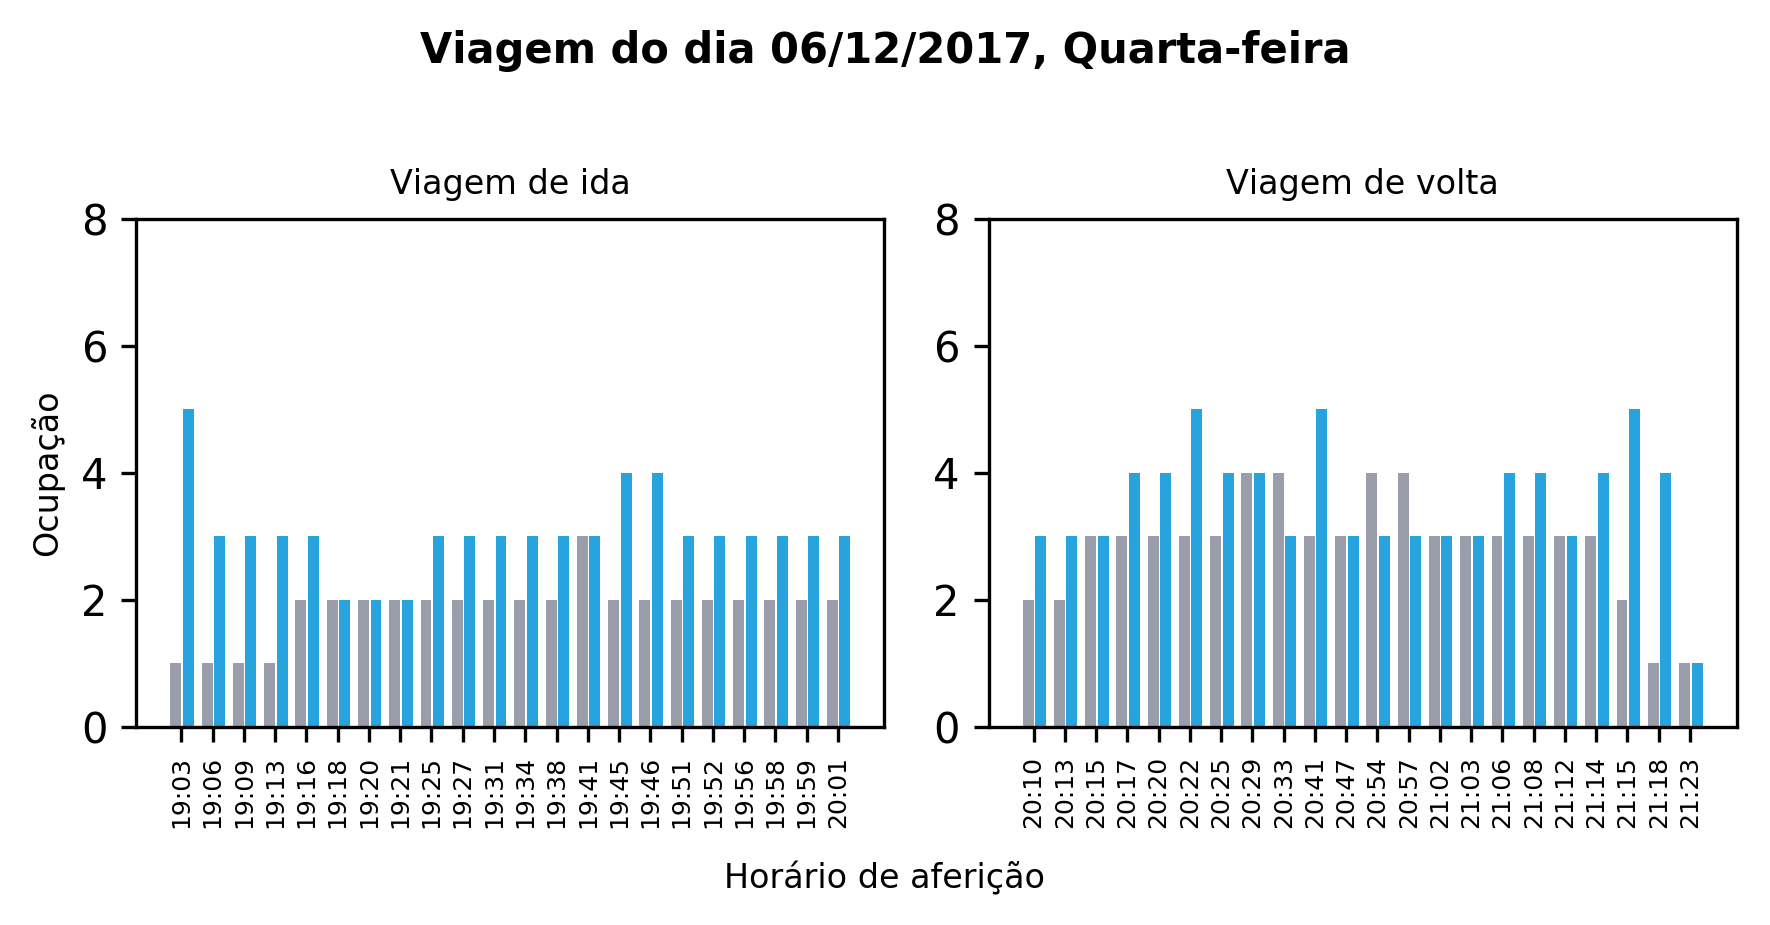

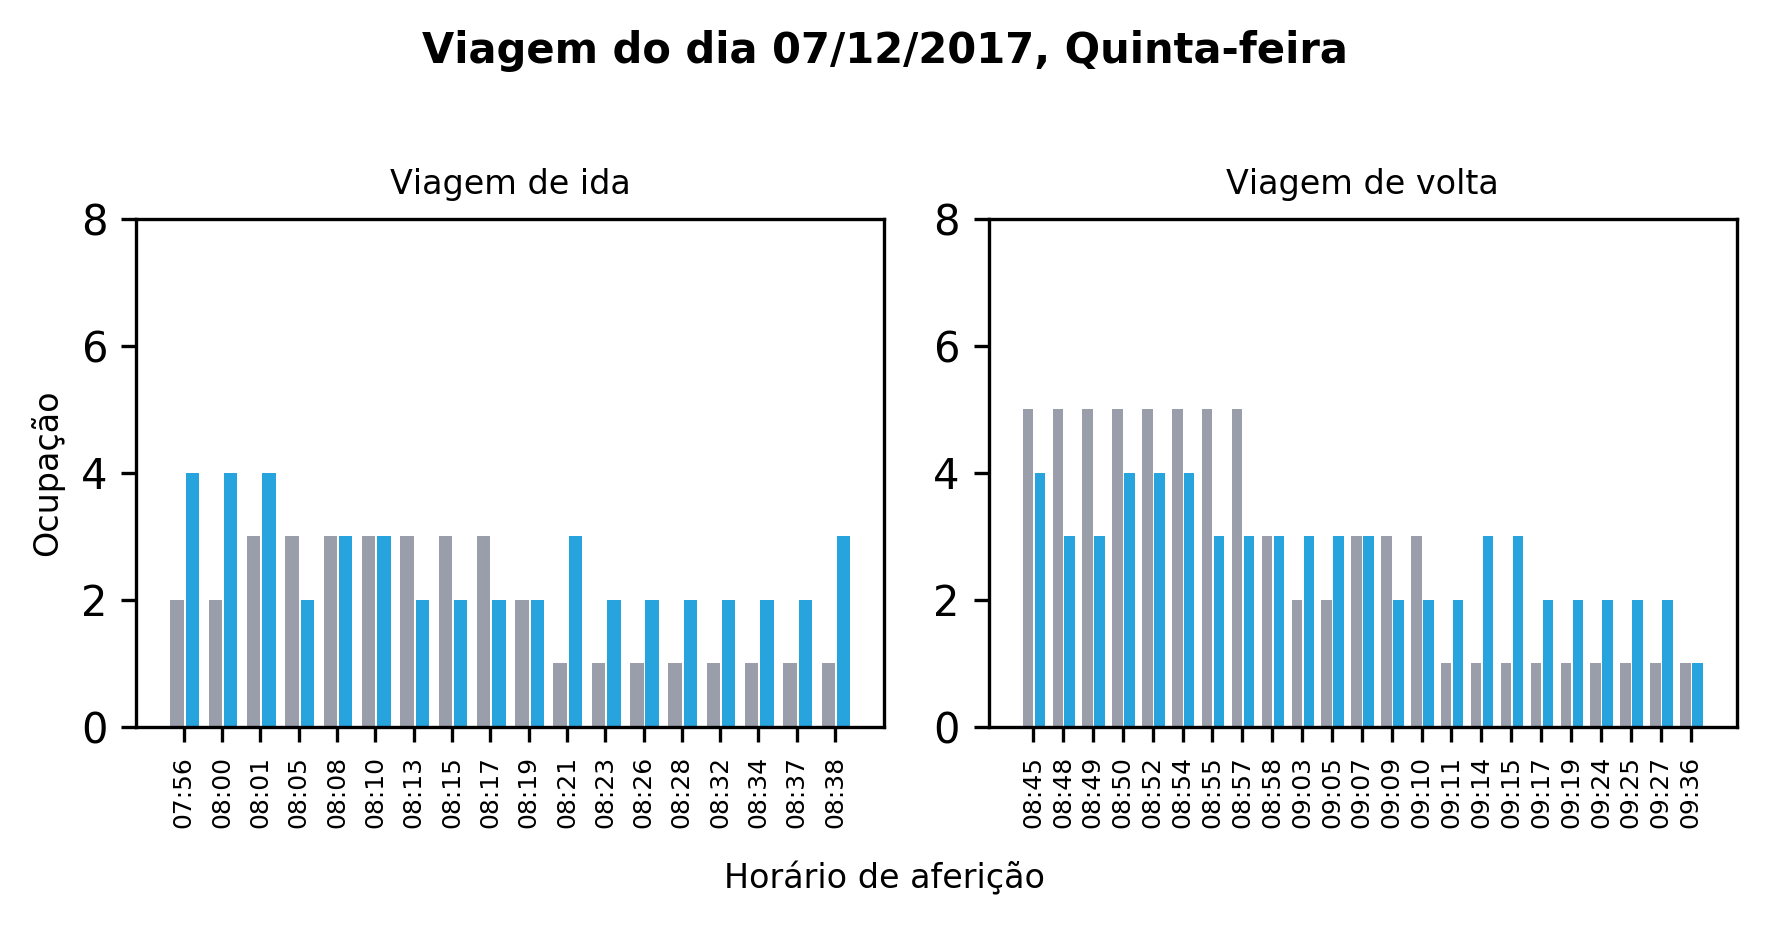

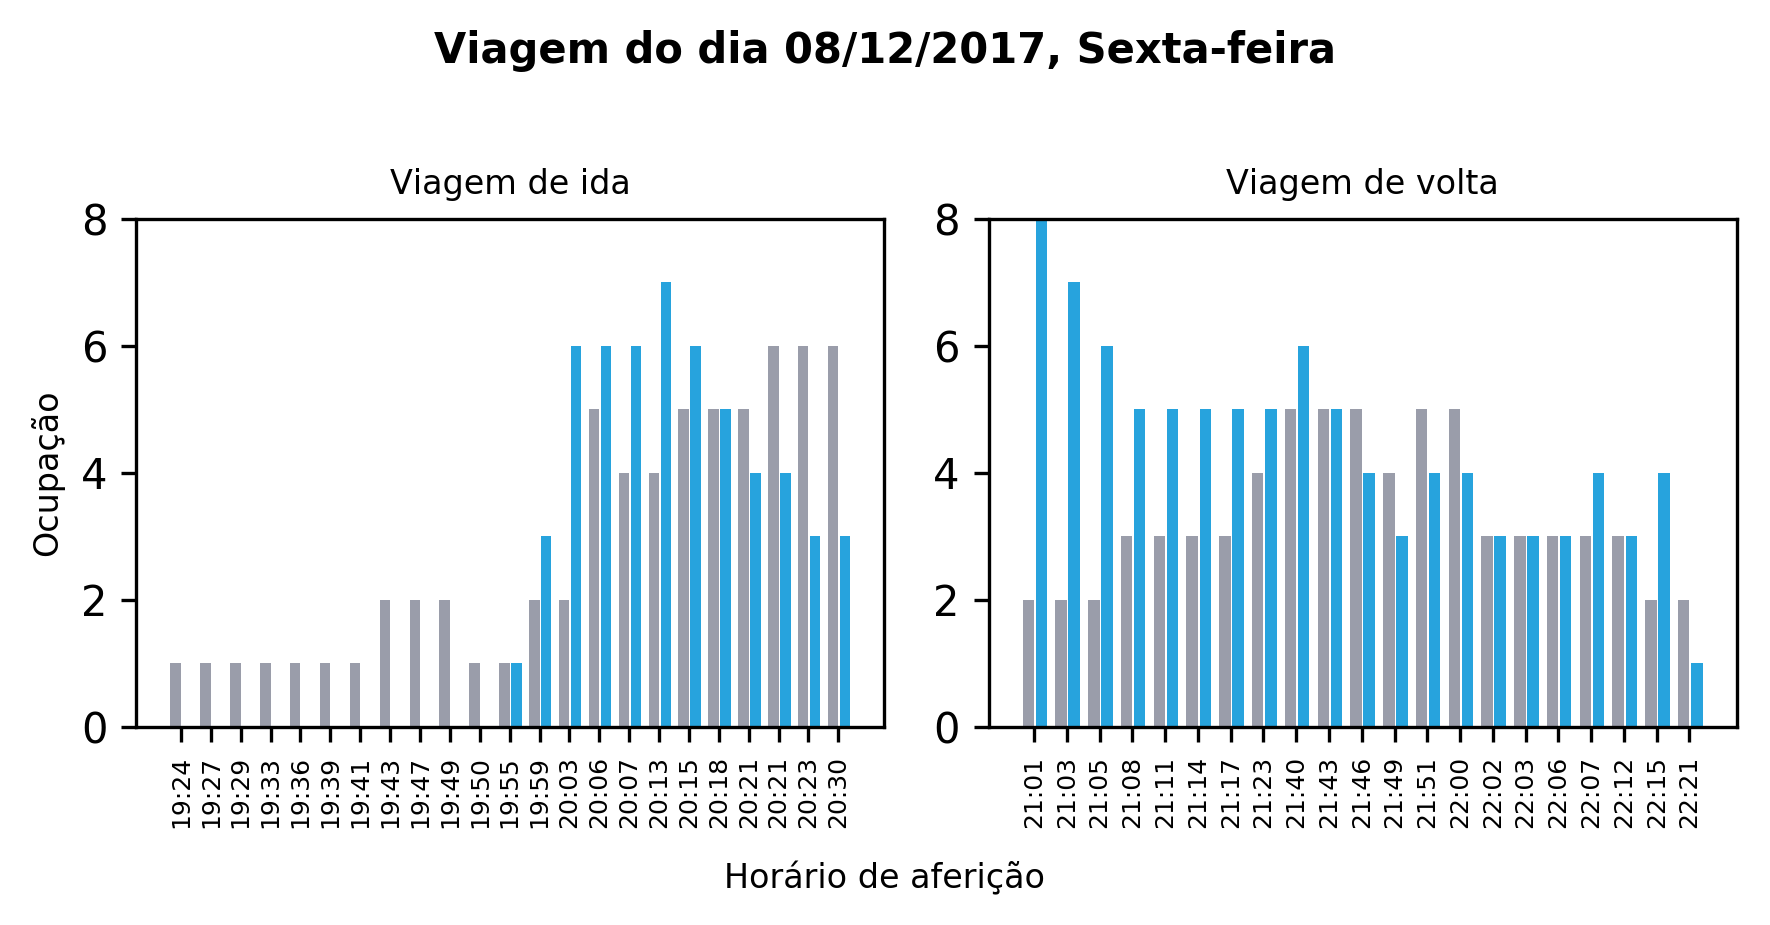

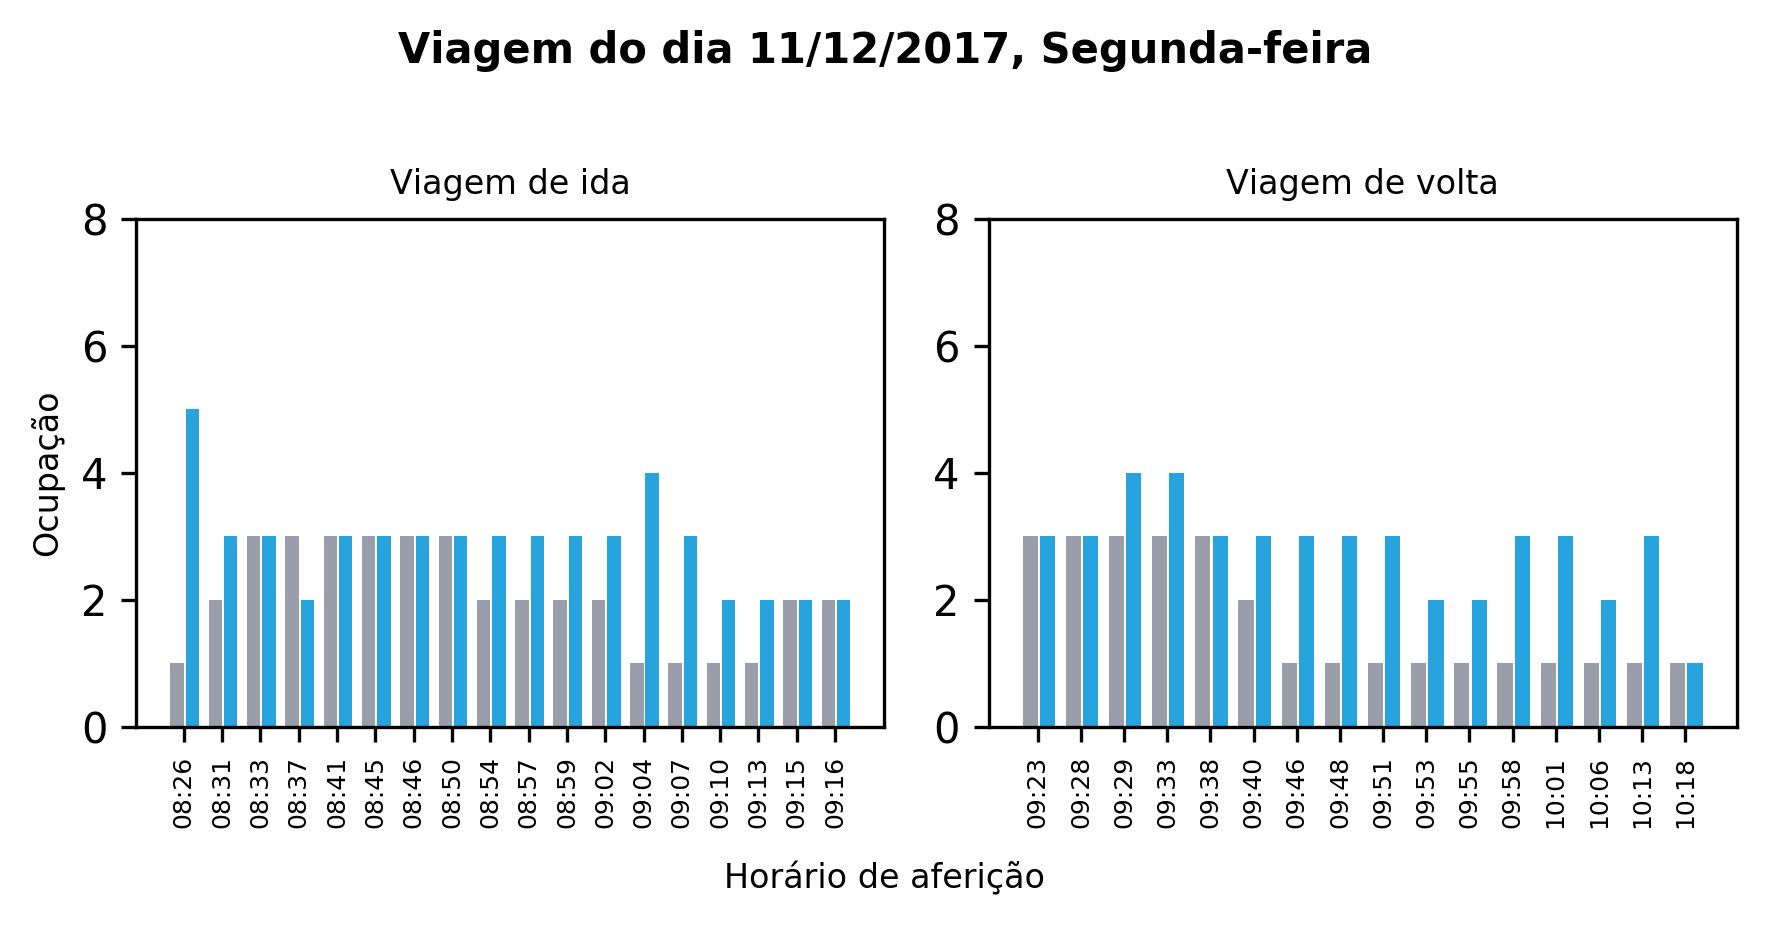

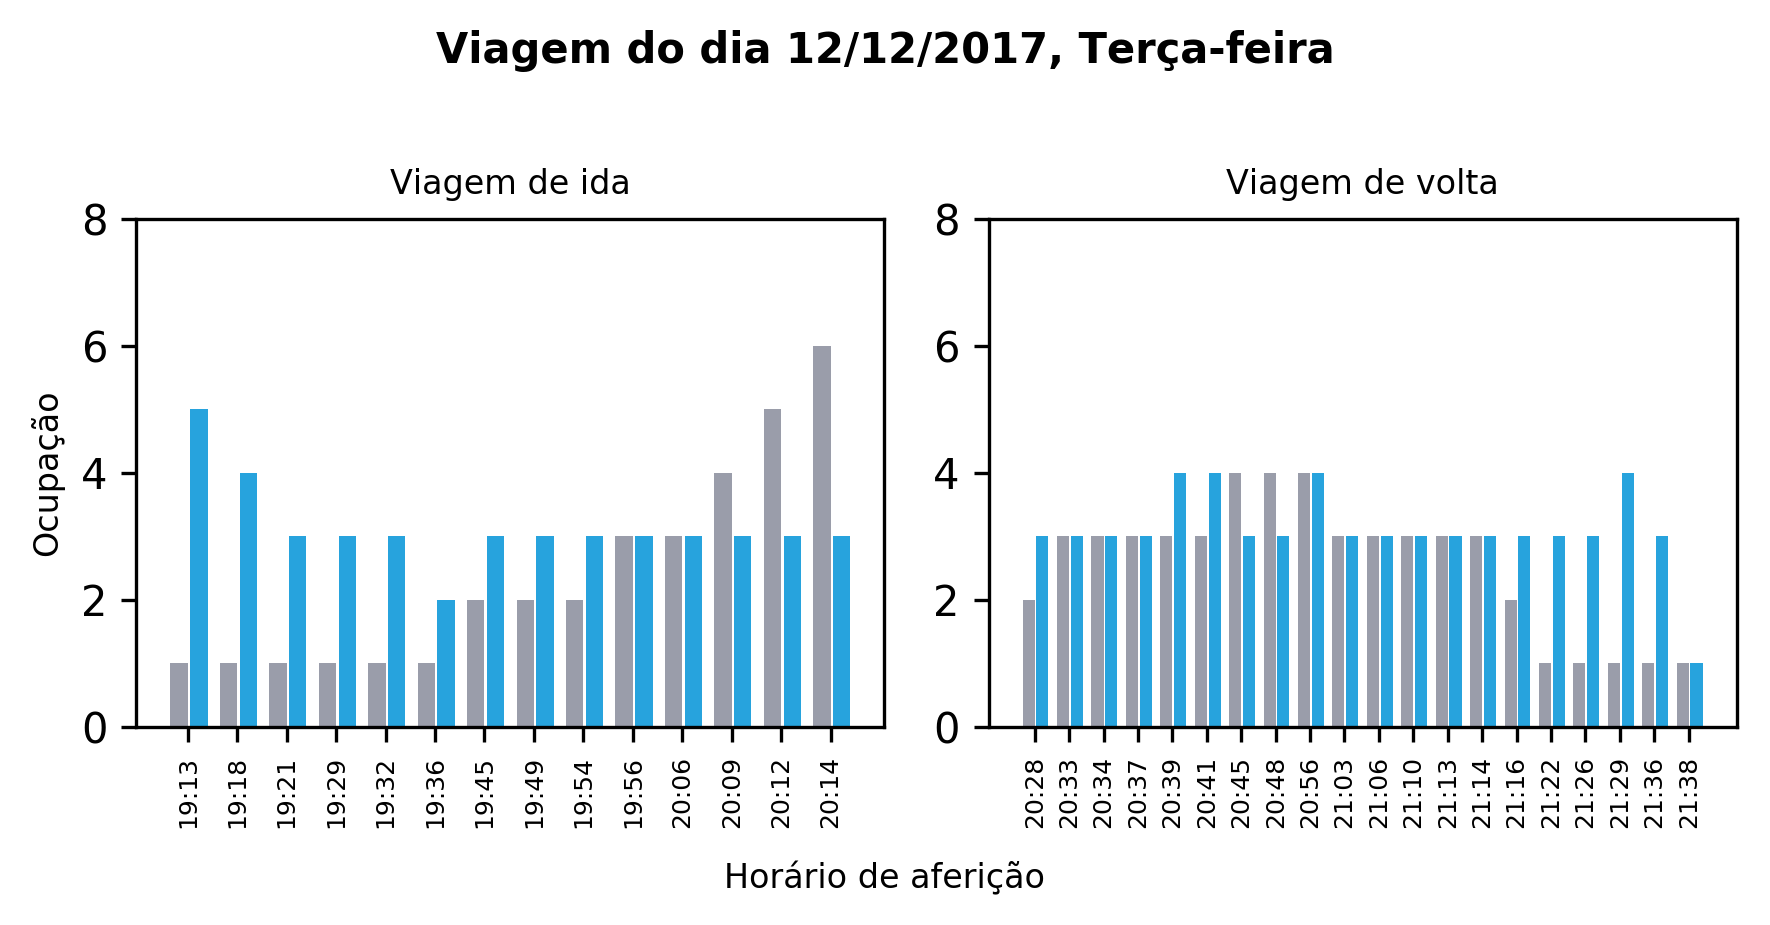

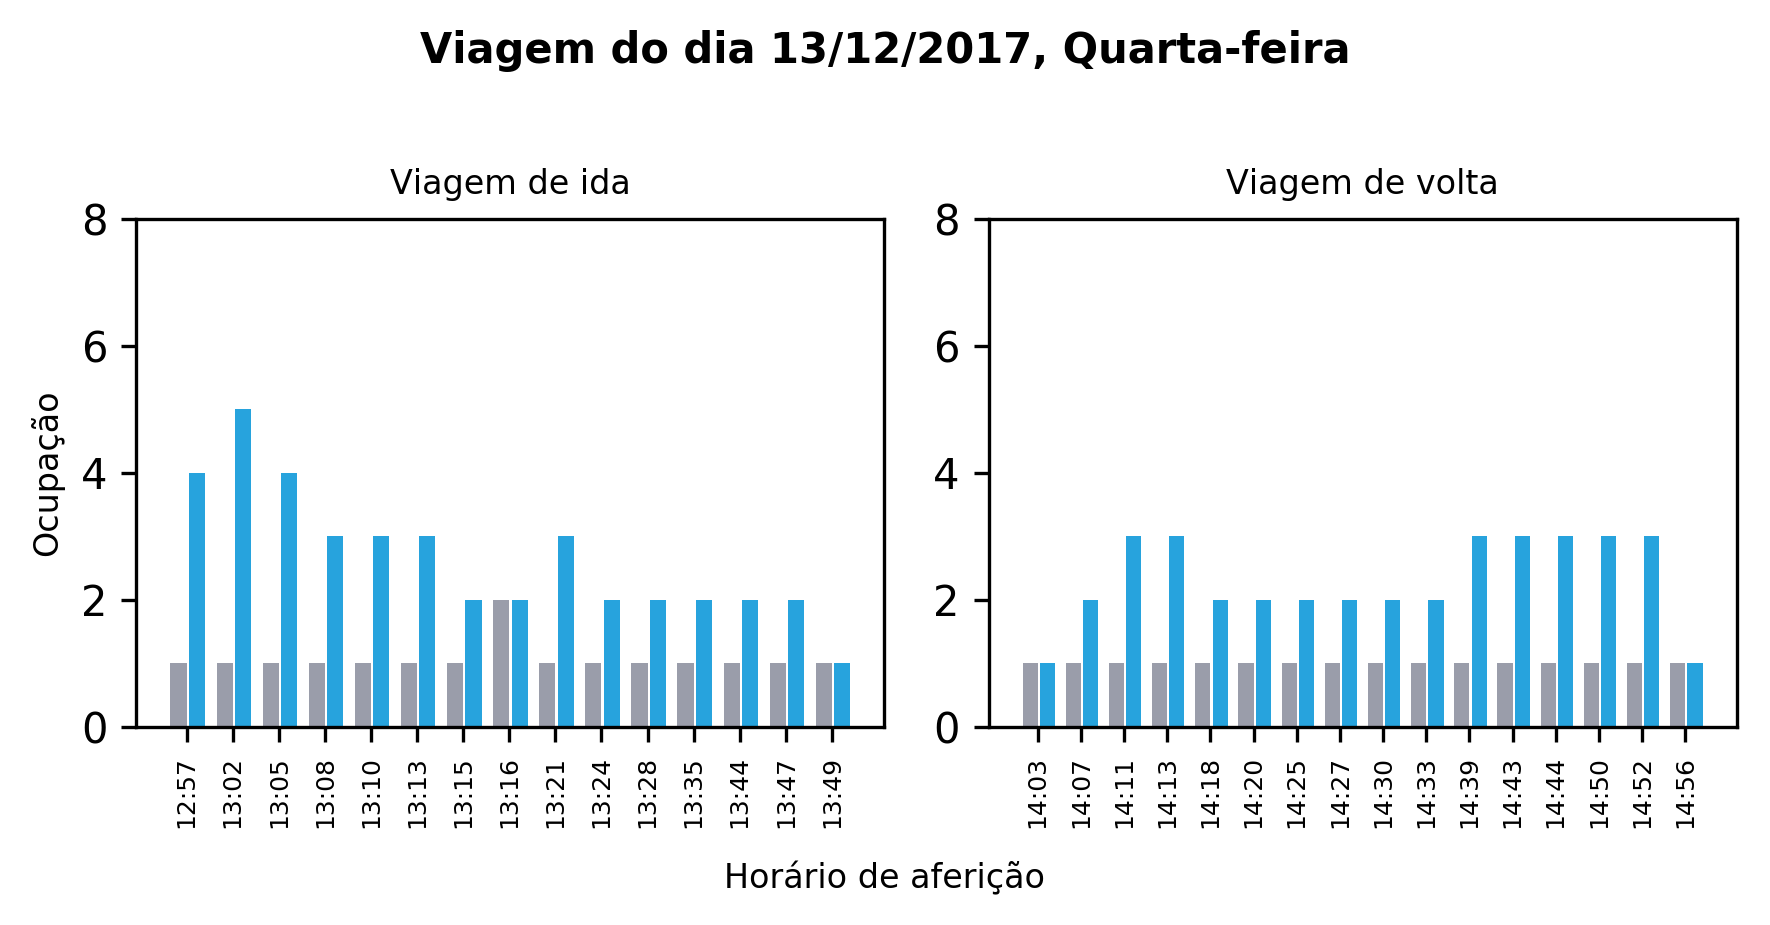

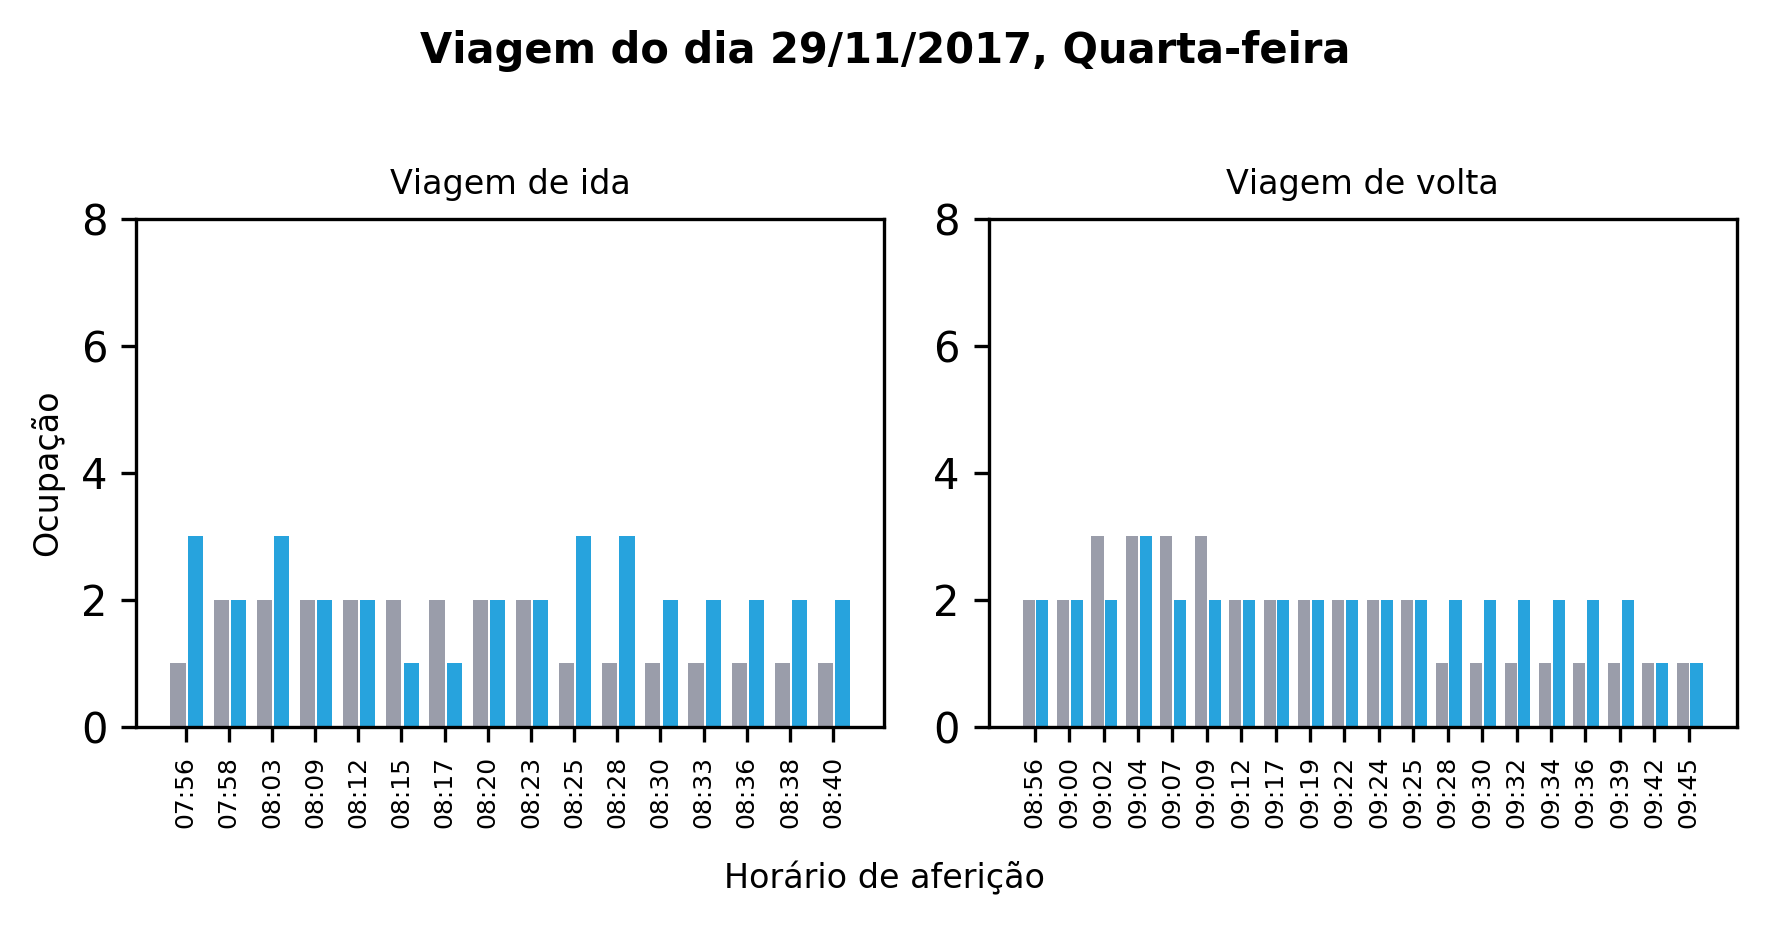

In [17]:
def translate_week(x):
    return {
        'Mon': 'Segunda-feira',
        'Tue': 'Terça-feira',
        'Wed': 'Quarta-feira',
        'Thu': 'Quinta-feira',
        'Fri': 'Sexta-feira',
        'Sat': 'Sábado',
        'Sun': 'Domingo'
    }[x]

day = udf(translate_week)

ALPHA = 0.20

def reject(p_value):
    return "✓" if 1-p_value < ALPHA else "✕"
    
distinct_date = (
    survey
    .select(
        date_format("date", "dd/MM/yyyy"),
        day(date_format("date", "EEE"))
    )
    .orderBy("date")
    .distinct()
)

dates = list(map(lambda x: (x[0], x[1]), distinct_date.toPandas().values.tolist()))

# Create the stats dataframe
nrows = np.arange(math.floor(len(dates) * 2))
stats = pd.DataFrame(columns=['date', 'direction', 'chi', 'p-value', 'reject'], index=nrows)

for i, (date, day) in enumerate(sorted(dates, key=lambda x: x[0])):
    data = (
        survey
        .filter((date_format("date", "dd/MM/yyyy") == date) & (col("occupation") != 8))
        .orderBy("timestamp")
    )

    fig, ax = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(6, 2.5))
    axes = ax.flatten()
    
    # Occupation dataframe
    o = (
        occupation
        .filter(col("date") == date)
#         (col("occupation") != 8)
        .select(col("window.start").alias("timestamp"), "count", "occupation")
        .cache()
    ).toPandas().set_index("timestamp")


    # Get the start/end timestamps for the round trip
    s = trips.filter((col("date") == date) & (col("direction") == 0)).select(col("end").alias("timestamp")).first()
    e = trips.filter((col("date") == date) & (col("direction") == 1)).select(col("start").alias("timestamp")).first()

    # Get first and second ride values
    aa = data.filter(col("timestamp") <= s["timestamp"].strftime("%Y-%m-%d %T")).toPandas().set_index("timestamp")
    bb = data.filter(col("timestamp") >= e["timestamp"].strftime("%Y-%m-%d %T")).toPandas().set_index("timestamp")
    
    a = pd.merge_asof(aa, o, left_index=True, right_index=True, suffixes=("_real", "_wifi"))
    b = pd.merge_asof(bb, o, left_index=True, right_index=True, suffixes=("_real", "_wifi"))
    
    # Graph variables
    w = 0.35 # bar width
    s = 0.05 # bar spacing
    xA = np.arange(len(a))
    xB = np.arange(len(b))
    
    # Build the graph
    axes[0].set_title("Viagem de ida", **text_kwargs)
    axes[0].bar(xA - w / 2, a.occupation_real.values, width=w, color=real_color)
    axes[0].bar(xA + w / 2 + s, a.occupation_wifi, width=w, color=wifi_color)
    axes[0].axes.set_ylabel("Ocupação", **text_kwargs)
    axes[0].axes.set_ybound(0, 8)
    axes[0].axes.set_xticks(xA)
    axes[0].axes.set_xticklabels(a.index.map(lambda x: x.strftime("%H:%M")), **labels_kwargs)

    axes[1].set_title("Viagem de volta", **text_kwargs)
    axes[1].bar(xB - w / 2, b.occupation_real, width=w, color=real_color)
    axes[1].bar(xB + w / 2 + s, b.occupation_wifi, width=w, color=wifi_color)
    axes[1].axes.set_ybound(0, 8)
    axes[1].axes.set_xticks(xB)
    axes[1].axes.set_xticklabels(b.index.map(lambda x: x.strftime("%H:%M")), **labels_kwargs)

    fig.text(0.5, s="Viagem do dia %s, %s" % (date, day), horizontalalignment='center', **title_kwargs)
    fig.text(0.5, -0.02, "Horário de aferição", horizontalalignment='center', **text_kwargs)
    fig.tight_layout()
    
    # Chi-squared test
    value, p_value = chisquare(a.occupation_real, a.occupation_wifi)
    sa = pd.DataFrame({'date': date, 'direction': 0, 'chi': value, 'p-value': 1-p_value, 'reject': reject(p_value)}, index=[i * 2])
    
    value, p_value = chisquare(b.occupation_real, b.occupation_wifi)
    sb = pd.DataFrame({'date': date, 'direction': 1, 'chi': value, 'p-value': 1-p_value, 'reject': reject(p_value)}, index=[i * 2 +1])
    
    stats.update(sa)
    stats.update(sb)

display(stats)
plt.show()

In [37]:
def save_dataset(df, name):
    try:
        shutil.rmtree("./data/ds/%s" % name)
    except FileNotFoundError:
        pass
    df.write.parquet("./data/ds/%s" % name)
    
# occupation.show()

rides_wifi = (
    occupation.alias("o")
    .join(trips.alias("t"), col("o.date") == col("t.date"), 'left')
    .filter(
        col("window.start")
        .cast("long")
        .between(
            col("t.start").cast("long"), 
            col("t.end").cast("long")
        )
    )
    .join(
        survey.alias("s"),
        date_format("s.timestamp", "yyyyMMddHHmm") == date_format("window.start", "yyyyMMddHHmm"),
    )
    .select(
        "o.date", 
        "direction", 
        col("window.start").alias("timestamp"),
        "count", 
        col("o.occupation").alias("wifi_occupation"), 
        col("s.occupation").alias("real_occupation")
    )   
)

save_dataset(rides_wifi, "occupation.parquet")

rides_wifi.toPandas()

,date,direction,timestamp,count,wifi_occupation,real_occupation
0,29/11/2017,0,2017-11-29 07:58:00,39,2,2
1,29/11/2017,0,2017-11-29 08:03:00,47,3,2
2,29/11/2017,0,2017-11-29 08:09:00,33,2,2
3,29/11/2017,0,2017-11-29 08:12:00,31,2,2
4,29/11/2017,0,2017-11-29 08:15:00,26,1,2
5,29/11/2017,0,2017-11-29 08:17:00,26,1,2
6,29/11/2017,0,2017-11-29 08:20:00,37,2,2
7,29/11/2017,0,2017-11-29 08:23:00,40,2,2
8,29/11/2017,0,2017-11-29 08:25:00,45,3,1
9,29/11/2017,0,2017-11-29 08:28:00,44,3,1
